In [1]:
# %%
# 1. 依赖
import torch
import numpy as np
from matplotlib import pyplot as plt
print("PyTorch version:", torch.__version__)

PyTorch version: 2.7.1+cpu


In [2]:
# %%
# 2. 载入 CIFAR-10 数据
from torchvision import datasets, transforms
# CIFAR 的 .data 属性是 numpy 数组，形状 (N, 32, 32, 3)
train_dataset = datasets.CIFAR10(root='./data', train=True,  download=True)
test_dataset  = datasets.CIFAR10(root='./data', train=False, download=True)

train_images, train_labels = train_dataset.data, train_dataset.targets
test_images , test_labels  = test_dataset.data , test_dataset.targets

Train images shape: (50000, 32, 32, 3)
Train labels shape: 50000


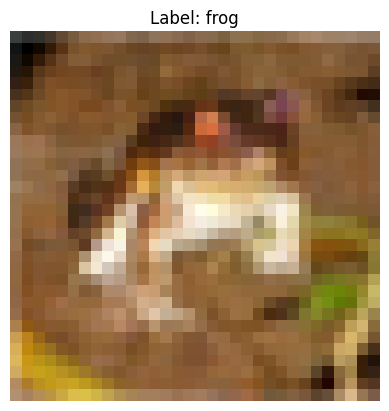

In [3]:
# %%
# 3. 数据概览 —— 查看形状 / 标签 / 一张示例图
print("Train images shape:", train_images.shape)   # (50000, 32, 32, 3)
print("Train labels shape:", len(train_labels))    # 50000
class_names = train_dataset.classes                # ['airplane', 'automobile', …]

plt.figure()
plt.imshow(train_images[0])        # 直接可视化
plt.title(f"Label: {class_names[train_labels[0]]}")
plt.axis(False)
plt.show()

In [4]:
# %%
# 4. 预处理与 DataLoader
#    (a) 归一化到 [0,1] 并转为 torch.float32
#    (b) 调整通道顺序 (H,W,C) → (C,H,W) 以符合 PyTorch
#    (c) 打包为 TensorDataset，再用 DataLoader
# helper：numpy → tensor，并归一化
def np_to_tensor(images_np):
    imgs = torch.from_numpy(images_np).permute(0, 3, 1, 2)     # (N,3,32,32)
    imgs = imgs.float() / 255.0                                # 0-1
    return imgs
train_images_t = np_to_tensor(train_images)
test_images_t  = np_to_tensor(test_images)
train_labels_t = torch.tensor(train_labels, dtype=torch.long)
test_labels_t  = torch.tensor(test_labels , dtype=torch.long)

from torch.utils.data import TensorDataset, DataLoader
batch_size = 64
train_loader = DataLoader(TensorDataset(train_images_t, train_labels_t),
                          batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(TensorDataset(test_images_t , test_labels_t ),
                          batch_size=batch_size, shuffle=False)

In [5]:
# %%
# 5. 构建一个简单 CNN
import torch.nn as nn

class CIFAR10Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)      # 32×30×30
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)     # 64×28×28
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3)     # 64×26×26
        self.pool  = nn.MaxPool2d(2, 2)                   # /2
        self.relu  = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc1  = nn.Linear(64*4*4, 128)                # 经过两次池化和三次卷积
        self.fc2  = nn.Linear(128, 10)

    def forward(self, x):
        x = self.relu(self.conv1(x))      # 32×30×30
        x = self.pool(x)                  # 32×15×15
        x = self.relu(self.conv2(x))      # 64×13×13
        x = self.pool(x)                  # 64×6×6
        x = self.relu(self.conv3(x))      # 64×4×4
        x = self.flatten(x)               # 64*4*4
        x = self.relu(self.fc1(x))
        x = self.fc2(x)                   # logits
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = CIFAR10Model().to(device)

In [6]:
# %%
# 6. 优化器、损失函数、准确率指标
import torch.optim as optim
from torchmetrics import Accuracy

optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn   = nn.CrossEntropyLoss()
acc_metric = Accuracy(task="multiclass", num_classes=10)

In [7]:
# %%
# 7. 训练单个 epoch 的函数
def train_epoch(model, loader, optimizer, loss_fn, acc_metric, device):
    model.train()
    epoch_loss = epoch_acc = 0.0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(x)
        loss = loss_fn(outputs, y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * x.size(0)
        preds = outputs.argmax(1)
        epoch_acc += acc_metric(preds.cpu(), y.cpu()) * x.size(0)
    size = len(loader.dataset)
    return epoch_loss/size, epoch_acc/size

In [8]:
# %%
# 8. 测试函数
def evaluate(model, loader, loss_fn, acc_metric, device):
    model.eval()
    epoch_loss = epoch_acc = 0.0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            loss = loss_fn(outputs, y)

            epoch_loss += loss.item() * x.size(0)
            preds = outputs.argmax(1)
            epoch_acc += acc_metric(preds.cpu(), y.cpu()) * x.size(0)
    size = len(loader.dataset)
    return epoch_loss/size, epoch_acc/size

In [9]:
# %%
# 9. 训练循环
num_epochs = 10
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader,
                                        optimizer, loss_fn, acc_metric, device)
    print(f"Epoch {epoch+1:2d}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")

Epoch  1/10 | Train Loss: 1.6757 | Train Acc: 0.3793
Epoch  2/10 | Train Loss: 1.3392 | Train Acc: 0.5150
Epoch  3/10 | Train Loss: 1.1856 | Train Acc: 0.5765
Epoch  4/10 | Train Loss: 1.0702 | Train Acc: 0.6214
Epoch  5/10 | Train Loss: 0.9836 | Train Acc: 0.6516
Epoch  6/10 | Train Loss: 0.9199 | Train Acc: 0.6745
Epoch  7/10 | Train Loss: 0.8688 | Train Acc: 0.6938
Epoch  8/10 | Train Loss: 0.8192 | Train Acc: 0.7121
Epoch  9/10 | Train Loss: 0.7836 | Train Acc: 0.7244
Epoch 10/10 | Train Loss: 0.7471 | Train Acc: 0.7366


In [10]:
# %%
# 🔟 评估
test_loss, test_acc = evaluate(model, test_loader,
                               loss_fn, acc_metric, device)
print(f"Test  Loss: {test_loss:.4f} | Test  Acc: {test_acc:.4f}")

Test  Loss: 0.8649 | Test  Acc: 0.6993


In [11]:
# %%
# 11. Softmax 概率，用于可视化
probability_model = nn.Sequential(model, nn.Softmax(dim=1)).eval()

with torch.no_grad():
    test_probs = probability_model(test_images_t.to(device)).cpu().numpy()

In [12]:
# %%
# 12. 可视化函数（与 Fashion-MNIST 部分一致）
def plot_image(i, probs, true_label, img):
    true_label, img = true_label[i], img[i]
    plt.grid(False); plt.xticks([]); plt.yticks([])
    plt.imshow(img)
    pred = np.argmax(probs)
    color = 'blue' if pred == true_label else 'red'
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[pred],
               100*np.max(probs), class_names[true_label]), color=color)

def plot_value_array(i, probs, true_label):
    true_label = true_label[i]
    plt.grid(False); plt.xticks(range(10)); plt.yticks([])
    bars = plt.bar(range(10), probs, color="#777777")
    plt.ylim([0, 1])
    pred = np.argmax(probs)
    bars[pred].set_color('red')
    bars[true_label].set_color('blue')

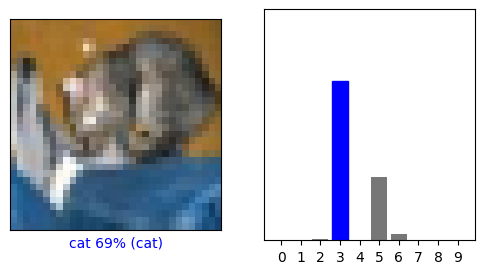

In [13]:
# %%
# 13. 单张预测示例
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1); plot_image(i, test_probs[i], test_labels, test_images)
plt.subplot(1,2,2); plot_value_array(i, test_probs[i], test_labels)
plt.show()

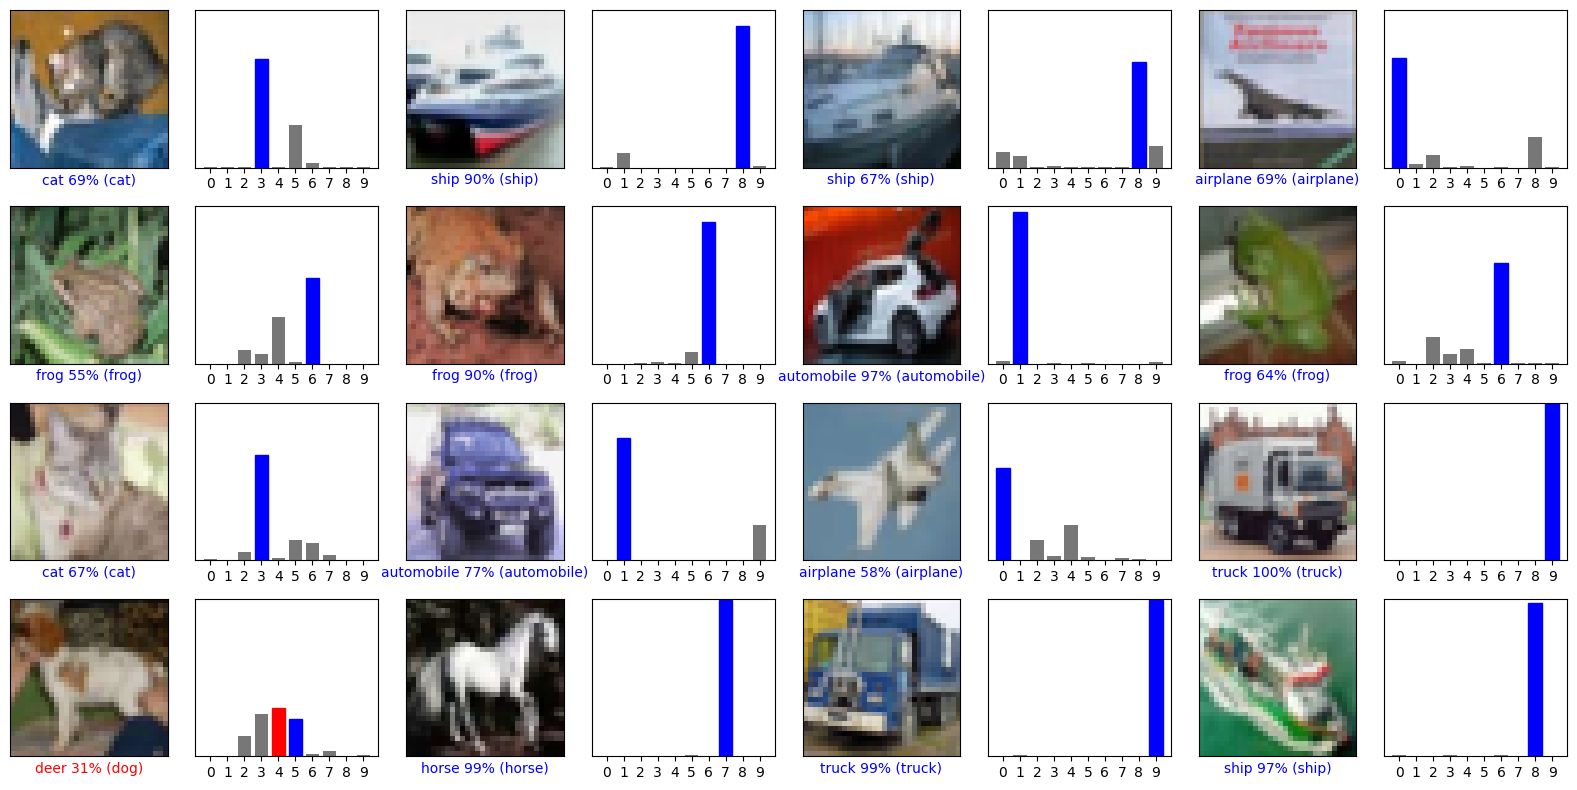

In [14]:
# %%
# 14. 多张可视化
num_rows, num_cols = 4, 4
num_images = num_rows * num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, test_probs[i], test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, test_probs[i], test_labels)
plt.tight_layout()
plt.show()